In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor


In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
df = pd.read_csv('data/Metro_Interstate_Traffic_Volume.CSV')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [5]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [6]:
df.isnull().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

In [7]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

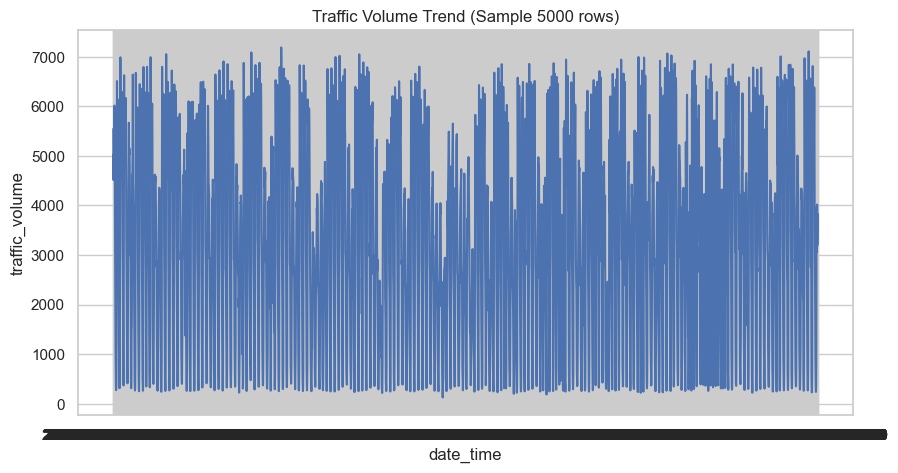

In [8]:
sns.lineplot(x='date_time', y='traffic_volume', data=df[:5000])
plt.title("Traffic Volume Trend (Sample 5000 rows)")
plt.show()

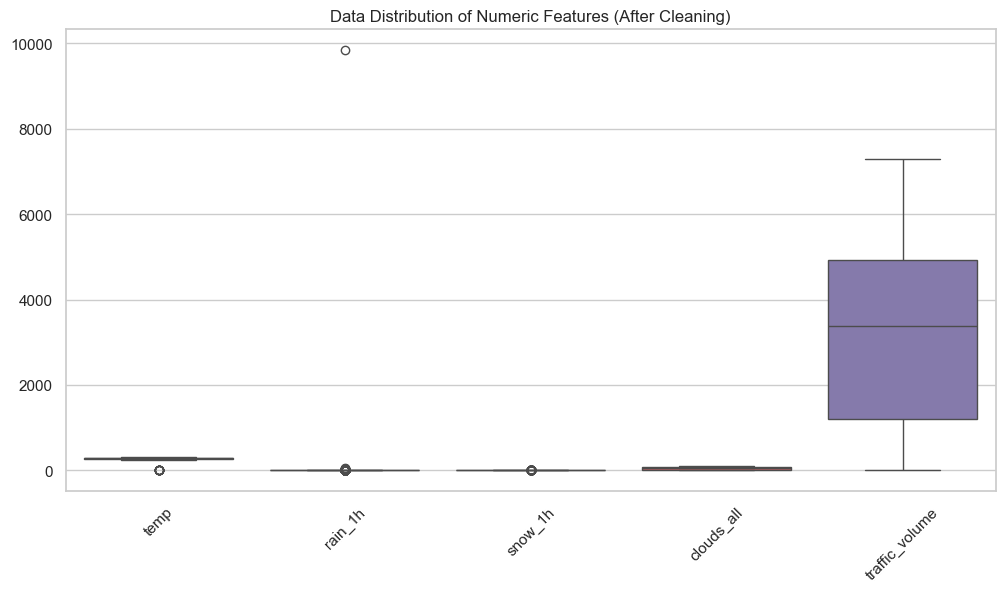

In [9]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Data Distribution of Numeric Features (After Cleaning)")
plt.xticks(rotation=45)
plt.show()

In [10]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['month'] = df['date_time'].dt.month
df['dayofweek'] = df['date_time'].dt.dayofweek
df.drop(['date_time'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)
df.dropna(inplace=True)

In [11]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,month,dayofweek,holiday_Columbus Day,holiday_Independence Day,...,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
0,288.28,0.0,0.0,40,5545,9,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,4516,10,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,4767,11,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,5026,12,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,4918,13,10,1,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
X= df.drop('traffic_volume', axis=1)
y= df['traffic_volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

In [13]:
#"LinearRegression" for prediction of data and behaivior
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
#print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False)); as this ML library does not work due to Sklearn version issue, I am gonna use manual calsulation of EMSE using numpy library;
mse = mean_squared_error(y_test, y_pred_lr)
print("Linear Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse)

Linear Regression R²: 0.17811825436277884
Linear Mean Squared Error: 3259883.2774369917
Linear Regression RMSE: 1805.514684913139


In [14]:
X_train.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'month',
       'dayofweek', 'holiday_Columbus Day', 'holiday_Independence Day',
       'holiday_Labor Day', 'holiday_Martin Luther King Jr Day',
       'holiday_Memorial Day', 'holiday_New Years Day', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow', 'weather_main_Squall', 'weather_main_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_freezing rain',
       'weather_description_haze',
       'weather_description_heavy intensity drizzle',
       'weather_description_heavy intensity rain',
       'we

In [15]:
#Prediction of Traffic Volume Using LinearReression Trained Model
input_data = {
    'temp': 290.0,
    'rain_1h': 0.0,
    'snow_1h': 0.0,
    'clouds_all': 60,
    'hour': 8,
    'month': 10,
    'dayofweek': 2,
    # Holiday columns
    'holiday_Columbus Day': 0,
    'holiday_Independence Day': 0,
    'holiday_Labor Day': 1,
    'holiday_Martin Luther King Jr Day': 0,
    'holiday_Memorial Day': 0,
    'holiday_New Years Day': 0,
    'holiday_State Fair': 0,
    'holiday_Thanksgiving Day': 0,
    'holiday_Veterans Day': 0,
    'holiday_Washingtons Birthday': 0,
    # Weather main
    'weather_main_Clouds': 1,
    'weather_main_Drizzle': 0,
    'weather_main_Fog': 0,
    'weather_main_Haze': 0,
    'weather_main_Mist': 0,
    'weather_main_Rain': 0,
    'weather_main_Smoke': 0,
    'weather_main_Snow': 0,
    'weather_main_Squall': 0,
    'weather_main_Thunderstorm': 0,
    # Weather description (only one = 1)
    'weather_description_Sky is Clear': 0,
    'weather_description_broken clouds': 0,
    'weather_description_drizzle': 0,
    'weather_description_few clouds': 0,
    'weather_description_fog': 0,
    'weather_description_freezing rain': 0,
    'weather_description_haze': 0,
    'weather_description_heavy intensity drizzle': 0,
    'weather_description_heavy intensity rain': 0,
    'weather_description_heavy snow': 0,
    'weather_description_light intensity drizzle': 0,
    'weather_description_light intensity shower rain': 0,
    'weather_description_light rain': 0,
    'weather_description_light rain and snow': 0,
    'weather_description_light shower snow': 0,
    'weather_description_light snow': 0,
    'weather_description_mist': 0,
    'weather_description_moderate rain': 0,
    'weather_description_overcast clouds': 0,
    'weather_description_proximity shower rain': 0,
    'weather_description_proximity thunderstorm': 0,
    'weather_description_proximity thunderstorm with drizzle': 0,
    'weather_description_proximity thunderstorm with rain': 0,
    'weather_description_scattered clouds': 1,  # only this one is 1
    'weather_description_shower drizzle': 0,
    'weather_description_shower snow': 0,
    'weather_description_sky is clear': 0,
    'weather_description_sleet': 0,
    'weather_description_smoke': 0,
    'weather_description_snow': 0,
    'weather_description_thunderstorm': 0,
    'weather_description_thunderstorm with drizzle': 0,
    'weather_description_thunderstorm with heavy rain': 0,
    'weather_description_thunderstorm with light drizzle': 0,
    'weather_description_thunderstorm with light rain': 0,
    'weather_description_thunderstorm with rain': 0,
    'weather_description_very heavy rain': 0
}
input_df = pd.DataFrame([input_data])
input_df = input_df[X_train.columns]
# Predict using Linear Regression trained model 
predicted_volume = lr.predict(input_df)
print(f"Predicted Traffic Volume: {predicted_volume[0]:,.0f} vehicles/hour")

Predicted Traffic Volume: 2,095 vehicles/hour


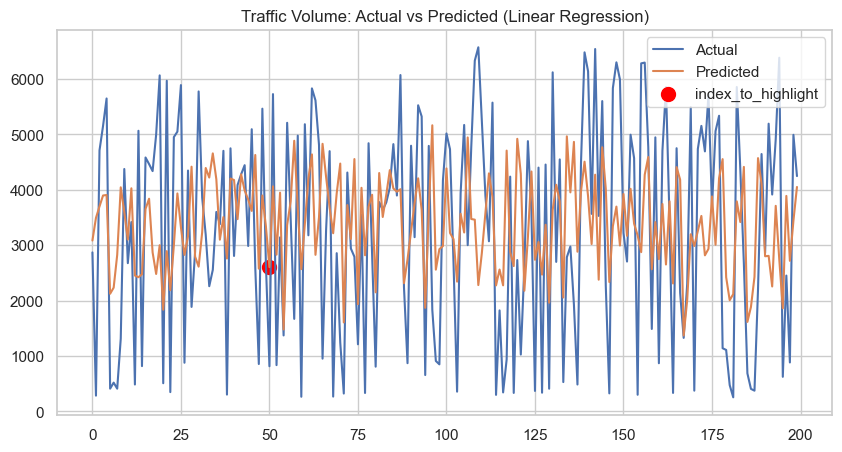

In [16]:
#Now showing visual plot of the predicted values as per Linear Regression
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_lr[:200], label='Predicted')
# Let's say I want to highlight the 50th point
index_to_highlight = 50
plt.scatter(index_to_highlight, y_pred_lr[index_to_highlight],
            color='red', s=100, label='index_to_highlight')
plt.legend()
plt.title("Traffic Volume: Actual vs Predicted (Linear Regression)")
plt.show()

In [17]:
#I am also using"RandomForestRegressor" for getting more accurate results due to nonlinear pattern of data, and show the difference from "LinearRegression" results
rf = RandomForestRegressor(n_estimators=100, random_state=53)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
#print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False)); as this ML library does not work due to Sklearn version issue, I am gonna use manual calsulation of EMSE using numpy library;
mse = mean_squared_error(y_test, y_pred_rf)
print("Random Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse)

Random Forest R²: 0.9480413174244097
Random Mean Squared Error: 206087.11818328637
Random Forest RMSE: 453.96819071746245


In [18]:
#Prediction of Traffic Volume Using RandomForestReressor Trained Model with Little different Method
feature_names = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'month',
       'dayofweek', 'holiday_Columbus Day', 'holiday_Independence Day',
       'holiday_Labor Day', 'holiday_Martin Luther King Jr Day',
       'holiday_Memorial Day', 'holiday_New Years Day', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow', 'weather_main_Squall', 'weather_main_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_freezing rain',
       'weather_description_haze',
       'weather_description_heavy intensity drizzle',
       'weather_description_heavy intensity rain',
       'weather_description_heavy snow',
       'weather_description_light intensity drizzle',
       'weather_description_light intensity shower rain',
       'weather_description_light rain',
       'weather_description_light rain and snow',
       'weather_description_light shower snow',
       'weather_description_light snow', 'weather_description_mist',
       'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity shower rain',
       'weather_description_proximity thunderstorm',
       'weather_description_proximity thunderstorm with drizzle',
       'weather_description_proximity thunderstorm with rain',
       'weather_description_scattered clouds',
       'weather_description_shower drizzle', 'weather_description_shower snow',
       'weather_description_sky is clear', 'weather_description_sleet',
       'weather_description_smoke', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with drizzle',
       'weather_description_thunderstorm with heavy rain',
       'weather_description_thunderstorm with light drizzle',
       'weather_description_thunderstorm with light rain',
       'weather_description_thunderstorm with rain',
       'weather_description_very heavy rain']
#turning all zeros
new_data = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)
#Inputing the datas for which I want the Traffic Volume
new_data.loc[0, 'temp'] = 290
new_data.loc[0, 'rain_1h'] = 0.0
new_data.loc[0, 'snow_1h'] = 0.0
new_data.loc[0, 'clouds_all'] = 75
new_data.loc[0, 'hour'] = 8
new_data.loc[0, 'month'] = 10
new_data.loc[0, 'dayofweek'] = 2
new_data.loc[0, 'holiday_Labor Day'] = 1
new_data.loc[0, 'weather_main_Clouds'] = 1
new_data.loc[0, 'weather_description_scattered clouds'] = 1
predicted_volume = rf.predict(new_data)
print(f"Predicted Traffic Volume: {predicted_volume[0]:,.0f} vehicles/hour")

Predicted Traffic Volume: 5,907 vehicles/hour


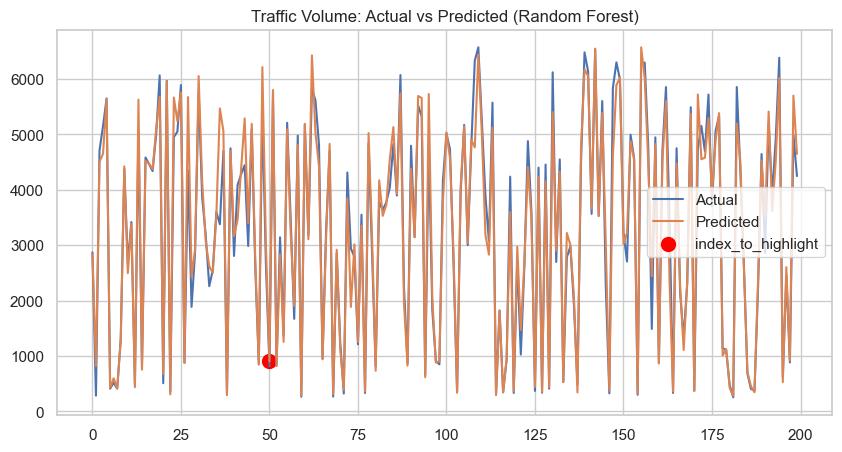

In [19]:
#Now showing visual plot of the predicted values as per Random Forest
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_rf[:200], label='Predicted')
index_to_highlight = 50
plt.scatter(index_to_highlight, y_pred_rf[index_to_highlight],
            color='red', s=100, label='index_to_highlight')
plt.legend()
plt.title("Traffic Volume: Actual vs Predicted (Random Forest)")
plt.show()

In [20]:
# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
#print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False)); as this ML library does not work due to Sklearn version issue, I am gonna use manual calsulation of EMSE using numpy library;
mse = mean_squared_error(y_test, y_pred_rf)
print("XGboost Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGboost Forest RMSE:", rmse)

XGBoost R²: 0.9519660472869873
XGboost Mean Squared Error: 206087.11818328637
XGboost Forest RMSE: 436.48614668738344


In [21]:
#Prediction of Traffic Volume Using XGBoost Trained Model with Little different Method
feature_names = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'month',
       'dayofweek', 'holiday_Columbus Day', 'holiday_Independence Day',
       'holiday_Labor Day', 'holiday_Martin Luther King Jr Day',
       'holiday_Memorial Day', 'holiday_New Years Day', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clouds',
       'weather_main_Drizzle', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow', 'weather_main_Squall', 'weather_main_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_freezing rain',
       'weather_description_haze',
       'weather_description_heavy intensity drizzle',
       'weather_description_heavy intensity rain',
       'weather_description_heavy snow',
       'weather_description_light intensity drizzle',
       'weather_description_light intensity shower rain',
       'weather_description_light rain',
       'weather_description_light rain and snow',
       'weather_description_light shower snow',
       'weather_description_light snow', 'weather_description_mist',
       'weather_description_moderate rain',
       'weather_description_overcast clouds',
       'weather_description_proximity shower rain',
       'weather_description_proximity thunderstorm',
       'weather_description_proximity thunderstorm with drizzle',
       'weather_description_proximity thunderstorm with rain',
       'weather_description_scattered clouds',
       'weather_description_shower drizzle', 'weather_description_shower snow',
       'weather_description_sky is clear', 'weather_description_sleet',
       'weather_description_smoke', 'weather_description_snow',
       'weather_description_thunderstorm',
       'weather_description_thunderstorm with drizzle',
       'weather_description_thunderstorm with heavy rain',
       'weather_description_thunderstorm with light drizzle',
       'weather_description_thunderstorm with light rain',
       'weather_description_thunderstorm with rain',
       'weather_description_very heavy rain']
#turning all zeros
new_data = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)
#Inputing the datas for which I want the Traffic Volume
new_data.loc[0, 'temp'] = 290
new_data.loc[0, 'rain_1h'] = 0.0
new_data.loc[0, 'snow_1h'] = 0.0
new_data.loc[0, 'clouds_all'] = 75
new_data.loc[0, 'hour'] = 8
new_data.loc[0, 'month'] = 10
new_data.loc[0, 'dayofweek'] = 2
new_data.loc[0, 'holiday_Labor Day'] = 1
new_data.loc[0, 'weather_main_Clouds'] = 1
new_data.loc[0, 'weather_description_scattered clouds'] = 1
predicted_volume = xgb_model.predict(new_data)
print(f"Predicted Traffic Volume: {predicted_volume[0]:,.0f} vehicles/hour")

Predicted Traffic Volume: 5,927 vehicles/hour


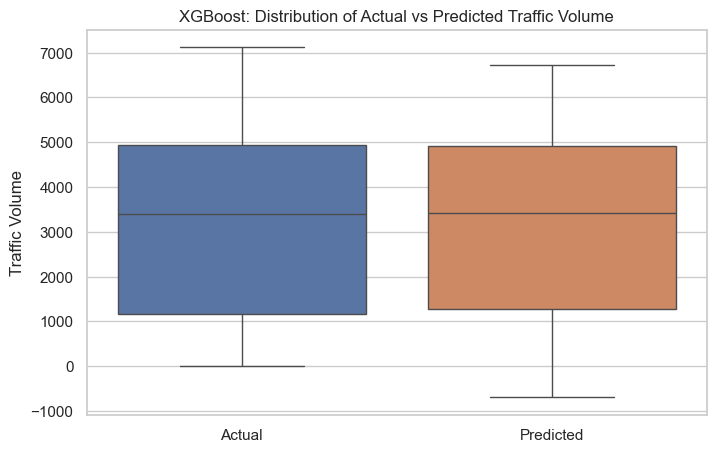

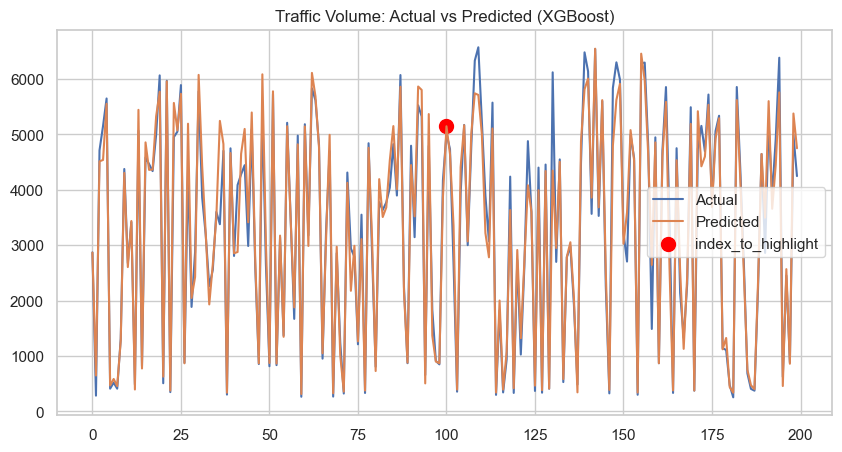

In [22]:
#Now showing visual plot of the predicted values as per XGboost model
plt.figure(figsize=(8,5))
sns.boxplot(data=[y_test, y_pred_xgb])
plt.xticks([0,1], ['Actual', 'Predicted'])
plt.title("XGBoost: Distribution of Actual vs Predicted Traffic Volume")
plt.ylabel("Traffic Volume")
plt.show()
#Frequency plot
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_xgb[:200], label='Predicted')
# Let's say I want to highlight the 100th point
index_to_highlight = 100
plt.scatter(index_to_highlight, y_pred_xgb[index_to_highlight],
            color='red', s=100, label='index_to_highlight')
plt.legend()
plt.title("Traffic Volume: Actual vs Predicted (XGBoost)")
plt.show()